# Alternative excision analysis

### Aim
Analyze genome-wide alternative excision in ICOP knockdowns and compare them with the puplished data of the ISWI1 knockdown. New KDs analyzed in this notebook: ICOP1-KD, ICOP2-KD, ICOP1_2-KD, ND7-KD

### Input
new enriched MAC DNA was send for whole genome sequencing. In the PARTIES pipeline the MILROD module (old one from PIES) was run on the bowtie mapped .bam files. Output is a .gff3 file that was zipped using gzip command.

### What this notebook does
1. Histogram of genome-wide alternative excision per IES (%)
2. Historgam of length distribution of alternatively excised IES in each sample
3. Barplot of absolute numbers of alternative excision events in each sample
4. Barplot of percentage of alternative excision events in each sample 
5. Histogram of length differences in partial internal and partial external excision events

### Import required packages

In [1]:
#!/usr/bin/env python

import sys
from Bio import SeqIO, Seq
from re import compile
import gzip
from scipy import *
from matplotlib import * 
import matplotlib.pyplot as plt
from pylab import * 
from collections import OrderedDict
import numpy as np
import pandas as pd
from functools import reduce

## Genome-wide alternative excision per IES (%)

In [2]:
# !! This is the old script that does not include 100% alternatively excised IESs !!!

#this script analyses the percentage of alternative excision for each IES
# incoorperate storage of alternative excision in data frames

kd_alt_fracs = []
fns = ["ND7_ppm-down_MILORD.gff3.gz","ISWI1_ppm-down_MILORD.gff3.gz","ICOP1_ppm-down_MILORD.gff3.gz",
       "ICOP2_ppm-down_MILORD.gff3.gz", "ICOP1_2_ppm_MILORD.gff3.gz"]

names = ["CTRL-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1/2-KD"]

count = int(-1)
dfs = []
columns = []

#loop through samples
for fn in fns:
    count += 1
    ies_d = {}
    alt_d = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d.setdefault(ies_id, 0)
                ies_d[ies_id] += len(read_names)
                alt_d.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d.setdefault(ies_id, 0)
                alt_d[ies_id] += len(read_names)
    
    # create a big data frame with all read counts
    # data frame with standard excised reads for sample
    df_ies = pd.DataFrame.from_dict(ies_d, orient = 'index', columns = [f'{names[count]}_std'])
    df_ies = df_ies.reset_index().rename(columns={'index': 'IES_ID'})
    
    # data frame with alternatively excised reads for sample
    df_alt = pd.DataFrame.from_dict(alt_d, orient = 'index', columns = [f'{names[count]}_alt'])
    df_alt = df_alt.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_data = pd.DataFrame.merge(df_ies, df_alt, on='IES_ID', how = 'outer')
    # calculate alternative excision percentage for each IES in the sample
    df_data[f"{names[count]}_frac"] = ((df_data[f'{names[count]}_alt'])/(df_data[f'{names[count]}_alt']\
                                                                        +df_data[f'{names[count]}_std']))*100
    # store sample data frame in list
    dfs.append(df_data)
    
    # generate metrics to print as table 
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50','IES==100']
    columns.append([names[count], np.nanmedian(df_data[f"{names[count]}_frac"]),
                    mean(df_data[f"{names[count]}_frac"]), len(ies_d), 
                    len(df_data[df_data[f"{names[count]}_frac"]== 0]),
                    len(df_data[df_data[f"{names[count]}_frac"] > 0]), 
                    len(df_data[df_data[f"{names[count]}_frac"] >= 50]),
                    len(df_data[df_data[f"{names[count]}_frac"] == 100])])
    
    
# combine all samples into one big data frame
df = reduce(lambda left,right: pd.merge(left,right,on=['IES_ID'], how='outer'), dfs).fillna(np.nan)

    

Table = pd.DataFrame(columns, columns = colnames)
print(Table)

#Table.to_csv("statistics_alt-ex_no100.csv")

       sample    median      mean  all IES  IES==0  IES>0  IES>=50  IES==100
0     CTRL-KD  0.000000  1.079470    40676   39165   1511      312         0
1    ISWI1-KD  4.166667  9.150118    43166   18309  24857     1174         0
2    ICOP1-KD  0.000000  6.984288    41348   28106  13242     1328         0
3    ICOP2-KD  0.000000  4.185507    40778   34061   6717      916         0
4  ICOP1/2-KD  0.000000  4.701517    40961   33897   7064     1181         0


In [3]:
#this script analyses the percentage of alternative excision for each IES
# incoorperate storage of alternative excision in data frames

kd_alt_fracs = []
fns = ["ND7_ppm-down_MILORD.gff3.gz","ISWI1_ppm-down_MILORD.gff3.gz","ICOP1_ppm-down_MILORD.gff3.gz",
       "ICOP2_ppm-down_MILORD.gff3.gz", "ICOP1_2_ppm_MILORD.gff3.gz"]

names = ["CTRL-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1/2-KD"]

count = int(-1)
dfs = []
columns = []

#loop through samples
for fn in fns:
    count += 1
    ies_d = {}
    alt_d = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')

            #for each properly excised IES store the number of reads
            if kind == 'IES':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                ies_d.setdefault(ies_id, 0)
                ies_d[ies_id] += len(read_names)
                alt_d.setdefault(ies_id, 0)
            #for each alternatively excised IES store the number of reads (adds up for subtypes)
            elif kind == 'ALTERNATIVE':
                read_names = atoms[-1].split(";")[10].replace("read_names=", '').split(",")
                alt_d.setdefault(ies_id, 0)
                alt_d[ies_id] += len(read_names)
                ies_d.setdefault(ies_id, 0)
    
    # create a big data frame with all read counts
    # data frame with standard excised reads for sample
    df_ies = pd.DataFrame.from_dict(ies_d, orient = 'index', columns = [f'{names[count]}_std'])
    df_ies = df_ies.reset_index().rename(columns={'index': 'IES_ID'})
    
    # data frame with alternatively excised reads for sample
    df_alt = pd.DataFrame.from_dict(alt_d, orient = 'index', columns = [f'{names[count]}_alt'])
    df_alt = df_alt.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_data = pd.DataFrame.merge(df_ies, df_alt, on='IES_ID', how = 'outer')
    # calculate alternative excision percentage for each IES in the sample
    df_data[f"{names[count]}_frac"] = ((df_data[f'{names[count]}_alt'])/(df_data[f'{names[count]}_alt']\
                                                                        +df_data[f'{names[count]}_std']))*100
    # store sample data frame in list
    dfs.append(df_data)
    
    # generate metrics to print as table 
    colnames = ['sample','median', 'mean', 'all IES','IES==0', 'IES>0','IES>=50','IES==100']
    columns.append([names[count], median(df_data[f"{names[count]}_frac"]),
                    mean(df_data[f"{names[count]}_frac"]), len(ies_d), 
                    len(df_data[df_data[f"{names[count]}_frac"]== 0]),
                    len(df_data[df_data[f"{names[count]}_frac"] > 0]), 
                    len(df_data[df_data[f"{names[count]}_frac"] >= 50]),
                    len(df_data[df_data[f"{names[count]}_frac"] == 100])])
    
    
# combine all samples into one big data frame
df = reduce(lambda left,right: pd.merge(left,right,on=['IES_ID'], how='outer'), dfs).fillna(np.nan)

    

table = pd.DataFrame(columns, columns = colnames)
print(table)

#table.to_csv("statistics_alt-ex.csv")

       sample    median       mean  all IES  IES==0  IES>0  IES>=50  IES==100
0     CTRL-KD  0.000000   2.590567    41307   39165   2142      943       631
1    ISWI1-KD  4.545455  10.831605    43980   18309  25671     1988       814
2    ICOP1-KD  0.000000   8.939917    42236   28106  14130     2216       888
3    ICOP2-KD  0.000000   5.992893    41562   34061   7501     1700       784
4  ICOP1/2-KD  0.000000   6.515922    41756   33897   7859     1976       795


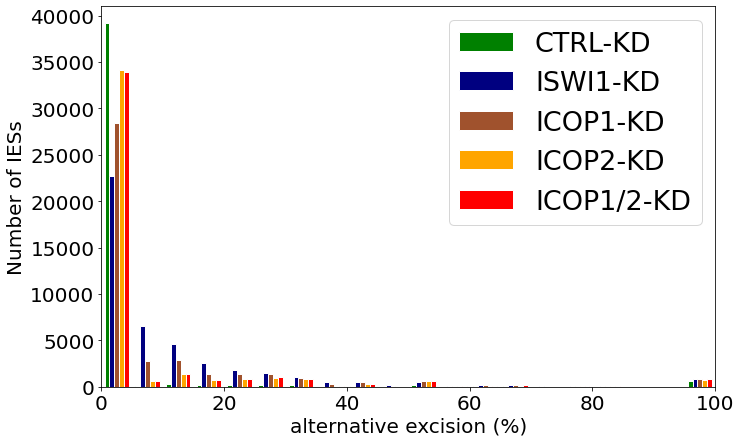

In [4]:
#plot the genome-wide alternative excision distribution (non-cropped)

# retrive fraction data
fractions = []
for na in names:
    fraction = df[f"{na}_frac"]
    fractions.append(fraction)
    
labels = ["CTRL-KD","ISWI1-KD","ICOP1-KD", "ICOP2-KD", "ICOP1/2-KD"]

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=labels)
axis(ymax=41000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 27);


#plt.savefig("ICOPs_alt-ex_100_down.pdf", bbox_inches='tight')

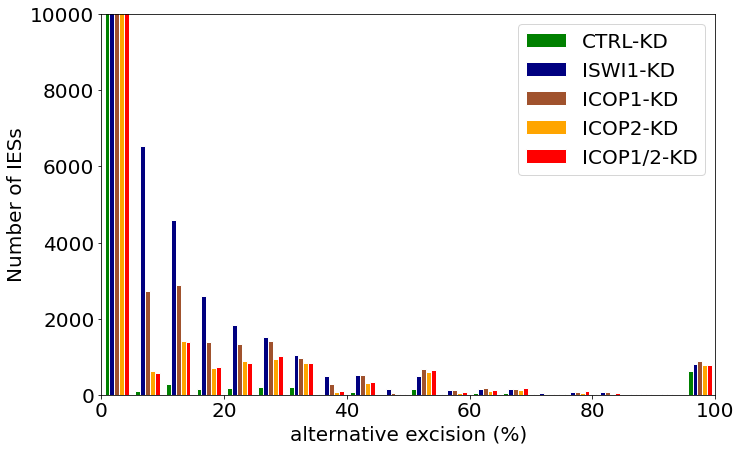

In [5]:
#plot the genome-wide alternative excision distribution (cropped)

plt.figure(figsize=(11,7))
hist(fractions, bins=20, ec='white', log=False, 
     color=['green', 'navy', 'sienna', 'orange', 'red'],
     label=labels)
axis(ymax=10000, xmax=100, xmin=0)
plt.ylabel("Number of IESs", wrap = True, fontsize = 20)
plt.xlabel("alternative excision (%)", wrap = True, fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize = 20);


#plt.savefig("ICOPs_alt-ex_100_downS.pdf", bbox_inches='tight')

### Length distribution for alternatively excised IESs

In [6]:
#this script acquires the lengths of alternatively excised IESs

# create data frame with reference IES lengths
df_length = pd.read_csv('IES_length.txt.gz',compression = 'gzip',sep=" ",\
                        header=None, names=['IES_ID','ref_length'])

dfs_len = OrderedDict([(na, []) for na in names])
count = int(-1)

#loop through the samples to get subtypes for alternative excision
for fn in fns:
    count += 1
    ies_len = {}
    alt_len = {}
    
    #for each line acquire the stored data
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'IES':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                ies_len[ies_id] = len(sequence)
            #for alternatively excised IES store the length of the alternative IES
            elif kind == 'ALTERNATIVE':
                sequence = atoms[-1].split(";")[11].replace("sequence=", '')
                alt_len.setdefault(ies_id, []).append(len(sequence))
                
    # data frame with alternative excised reads lengths for sample
    df_allen = pd.DataFrame.from_dict(alt_len, orient = 'index')
    df_allen = df_allen.reset_index().rename(columns={'index': 'IES_ID'})
    
    # combine to one data frame per sample 
    df_altlen = pd.DataFrame.merge(df_length, df_allen, on='IES_ID', how = 'inner')
    
    # store sample data frame in list
    dfs_len[names[count]] = df_altlen


In [7]:
# extract the alternative lengths from the data frames

# Create an empty dictionary to store the extracted values
extracted_values = {}

# get reference values
extracted_values['ref_length'] = df_length['ref_length']

# Iterate over each sample in the dictionary
for sample_name, df in dfs_len.items():
    # Extract values from the dataframe, ignoring the first two columns
    extracted_values[sample_name] = df.iloc[:, 2:].values.flatten().tolist()

    # Remove NaN values from the extracted list
    extracted_values[sample_name] = [x for x in extracted_values[sample_name] if (~np.isnan(x))]

In [8]:
# get statistics for the alternative lengths

table_rows = []

for name, values in extracted_values.items():
    sample = name
    minimum = min(values)
    maxium = max(values)
    
    table_rows.append([name, min(values), max(values), np.mean(values), np.median(values)])
    
table_names = ['sample','min','max', 'mean', 'median']
table2 = pd.DataFrame(table_rows, columns = table_names)
print(table2)
#table2.to_csv("min-max_length_alt-ex.csv")

       sample   min     max        mean  median
0  ref_length  20.0  5314.0   79.129274    50.0
1     CTRL-KD   9.0  9032.0  260.553991    77.0
2    ISWI1-KD   5.0  9892.0  208.643793    73.0
3    ICOP1-KD   6.0  9590.0  197.725373    67.0
4    ICOP2-KD   5.0  9467.0  143.038359    65.0
5  ICOP1/2-KD   5.0  9878.0  185.156519    67.0


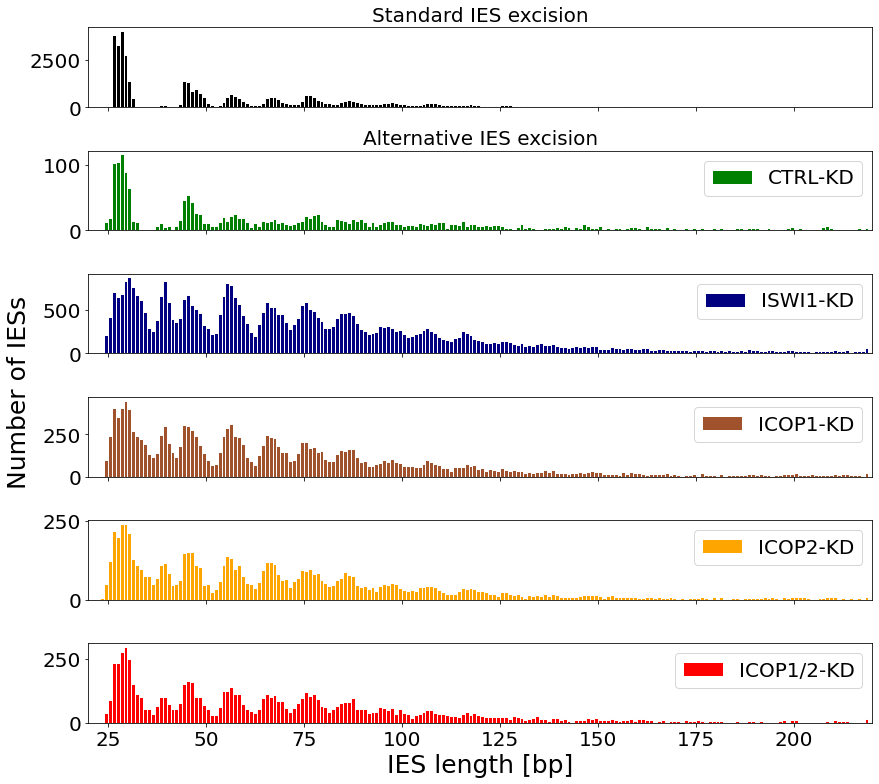

In [9]:
# plot the lengths of alternatively excised IESs

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize = (12,11));

ax0.hist(extracted_values['ref_length'], bins=range(20, 220, 1), ec='white', fc='black');
ax1.hist(extracted_values[names[0]], bins=range(20, 220, 1), ec='white', fc='green', 
         label = "CTRL-KD");
ax2.hist(extracted_values[names[1]], bins=range(20, 220, 1), ec='white', fc='navy', 
         label = "ISWI1-KD");
ax3.hist(extracted_values[names[2]], bins=range(20, 220, 1), ec='white', fc='sienna', 
         label = "ICOP1-KD");
ax4.hist(extracted_values[names[3]], bins=range(20, 220, 1), ec='white', fc='orange', 
         label = "ICOP2-KD");
ax5.hist(extracted_values[names[4]], bins=range(20, 220, 1), ec='white', fc='red', 
         label = "ICOP1/2-KD");

ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);
ax5.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax5.set_xlabel('IES length [bp]', fontsize=25)
ax5.set_xlim([20,220]);

fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

#fig.savefig("ICOPs_alt_length_down.pdf", bbox_inches='tight')

In [10]:
# where do the IESs in the forbidden peak come from?

# Create an empty dictionary to store the extracted values
forbidden_len = {}
forbidden_id = {}

# Iterate over each sample in the dictionary
for sample_name, df in dfs_len.items():
    # Initialize an empty list to store the extracted reference lengths
    ref_lengths = []
    ref_ids = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Iterate over each value in the row, starting from the third column
        for value in row.values[2:]:
            # Check if the value is between 34 and 44 (inclusive)
            if 34 <= value <= 44:
                # Retrieve the corresponding reference length from the second column
                ref_length = row['ref_length']
                ref_id = row['IES_ID']
                # Append the reference length to the list
                ref_lengths.append(ref_length)
                ref_ids.append(ref_id)

    # Store the extracted reference lengths in the dictionary using the sample name as the key
    forbidden_len[sample_name] = ref_lengths
    forbidden_id[sample_name] = ref_ids

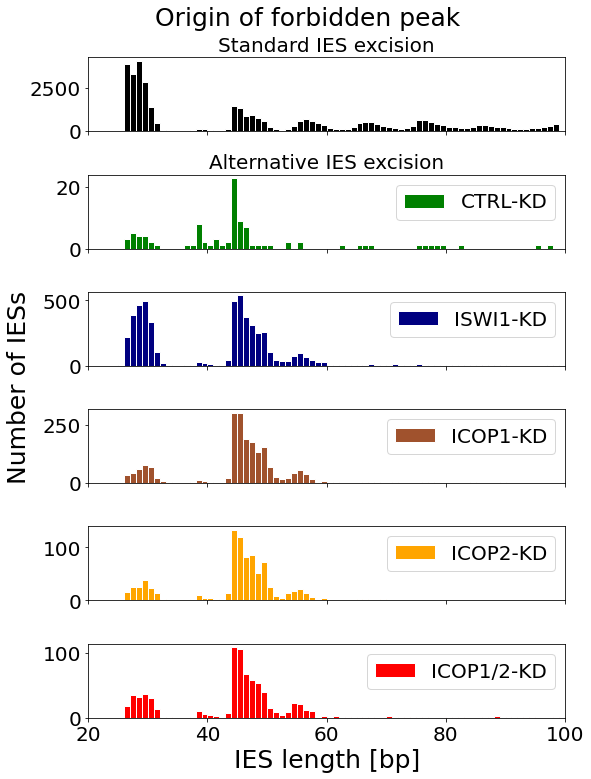

In [11]:
# plot the lengths form where the forbidden peak comes from

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, ncols=1, sharex=True, figsize = (8,11));

ax0.hist(extracted_values['ref_length'], bins=range(20, 100, 1), ec='white', fc='black');
ax1.hist(forbidden_len[names[0]], bins=range(20, 100, 1), ec='white', fc='green', 
         label = "CTRL-KD");
ax2.hist(forbidden_len[names[1]], bins=range(20, 100, 1), ec='white', fc='navy', 
         label = "ISWI1-KD");
ax3.hist(forbidden_len[names[2]], bins=range(20, 100, 1), ec='white', fc='sienna', 
         label = "ICOP1-KD");
ax4.hist(forbidden_len[names[3]], bins=range(20, 100, 1), ec='white', fc='orange', 
         label = "ICOP2-KD");
ax5.hist(forbidden_len[names[4]], bins=range(20, 100, 1), ec='white', fc='red', 
         label = "ICOP1/2-KD");

ax1.legend(fontsize=20);
ax2.legend(fontsize=20);
ax3.legend(fontsize=20);
ax4.legend(fontsize=20);
ax5.legend(fontsize=20);

ax0.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)

ax0.set_title("Standard IES excision", fontsize=20)
ax1.set_title("Alternative IES excision", fontsize=20)

ax5.set_xlabel('IES length [bp]', fontsize=25)
ax5.set_xlim([20,100]);

fig.suptitle("Origin of forbidden peak", fontsize=25);
fig.text(0.00001, 0.5, 'Number of IESs', ha='center', va='center', fontsize=25, rotation='vertical');
fig.tight_layout();

#fig.savefig("ICOPs_alt_length_down_oriFB.pdf", bbox_inches='tight')

## Frequencies of alternative excision types
This script get the numbers of types of alternative excsision in each sample and displays in barplot

In [12]:
#this script acquires the type of alternative excision genome wide

count = int(-1)

#to have the date sorted by KDs also make a dict
subs = OrderedDict([(na, []) for na in names])

# lists for boxplot
headers = []
p_internal = []
p_external = []
internal = []
external = []
overlap = []

#lists for proportional boxplots
prop_p_internal = []
prop_p_external = []
prop_internal = []
prop_external = []
prop_overlap = []

for fn in fns:
    count += 1
    part_in = 0
    part_ex = 0
    inter = 0
    exter = 0
    over = 0
    for line in gzip.open(fn, mode='rt'):
        if line[0] != '#':
            atoms = line.split()  
        
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
        
            if kind == 'ALTERNATIVE':
                if subtype == 'PARTIAL_INTERNAL':
                    part_in += 1
                if subtype == 'PARTIAL_EXTERNAL':
                    part_ex += 1
                if subtype == 'INTERNAL':
                    inter += 1
                if subtype == 'EXTERNAL':
                    exter += 1
                if subtype == 'OVERLAPPING':
                    over += 1
    
    #store data ordered by KDs in dict
    alt_list = [part_in, part_ex, inter, exter, over]
    subs[names[count]].append(alt_list)
    
    #for box plots store them in seperate lists
    headers.append(names[count])
    p_internal.append(part_in)
    p_external.append(part_ex)
    internal.append(inter)
    external.append(exter)
    overlap.append(over)
    
    #for proportional boxplot store percentages in seperate lists
    prop_part_in = part_in/sum(subs[names[count]])
    prop_part_ex = part_ex/sum(subs[names[count]])
    prop_inter = inter/sum(subs[names[count]])
    prop_exter = exter/sum(subs[names[count]])
    prop_over = over/sum(subs[names[count]])
    
    prop_p_internal.append(prop_part_in)
    prop_p_external.append(prop_part_ex)
    prop_internal.append(prop_inter)
    prop_external.append(prop_exter)
    prop_overlap.append(prop_over)
    

In [13]:
conames = list(subs.keys())
co = []
index = ["partial_internal", "partial_external", "internal", "external", "overlap"]
to_append = [prop_p_internal, prop_p_external, prop_internal, prop_external, prop_overlap]
for u in to_append:
    co.append(u)
tab = pd.DataFrame(co, columns = conames, index = index)
print(tab)
#tab.to_csv('ICOP-alex-events.csv')

                   CTRL-KD  ISWI1-KD  ICOP1-KD  ICOP2-KD  ICOP1/2-KD
partial_internal  0.306018  0.426567  0.566489  0.573521    0.470202
partial_external  0.328638  0.420097  0.277482  0.277229    0.337672
internal          0.030730  0.042641  0.038294  0.029641    0.052065
external          0.065728  0.041003  0.041795  0.026154    0.032380
overlap           0.268886  0.069693  0.075941  0.093456    0.107681


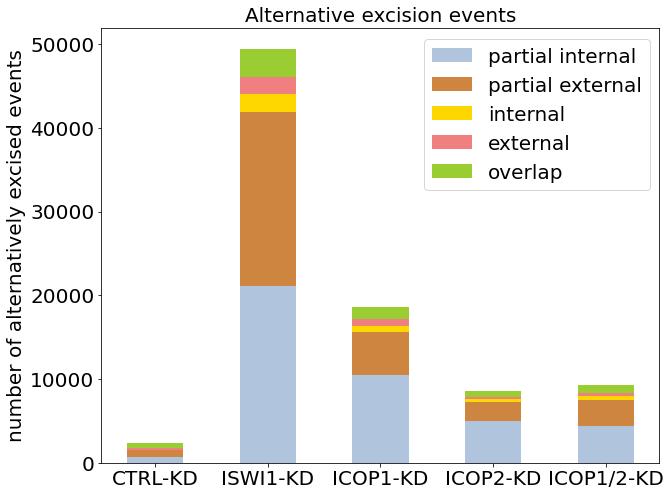

In [14]:
# stacked bar plot with absolut number as y-axis
width = 0.5       # the width of the bars: can also be len(x) sequence
n_p_internal = np.array(p_internal)
n_p_external = np.array(p_external)
n_internal = np.array(internal)
n_external = np.array(external)
n_overlap = np.array(overlap)


# make figure
fig, ax = plt.subplots(figsize = (10,8))

ax.bar(headers, n_p_internal, width, label='partial internal', color='lightsteelblue')
ax.bar(headers, n_p_external, width, bottom=n_p_internal, label='partial external', color='peru')
ax.bar(headers, n_internal, width, bottom=(n_p_internal+n_p_external), label='internal', color='gold')
ax.bar(headers, n_external, width, bottom=(n_p_internal+n_p_external+n_internal), label='external', 
       color='lightcoral')
ax.bar(headers, n_overlap, width, bottom=(n_p_internal+n_p_external+n_internal+n_external), 
       label='overlap', color='yellowgreen')

ax.set_ylabel('number of alternatively excised events', wrap = True, fontsize = 20)
ax.set_title('Alternative excision events', wrap = True, fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc='center left', bbox_to_anchor=(0.56, 0.8), fancybox=True, fontsize = 20);

#fig.savefig("ICOPs_ex_events.pdf", bbox_inches='tight')

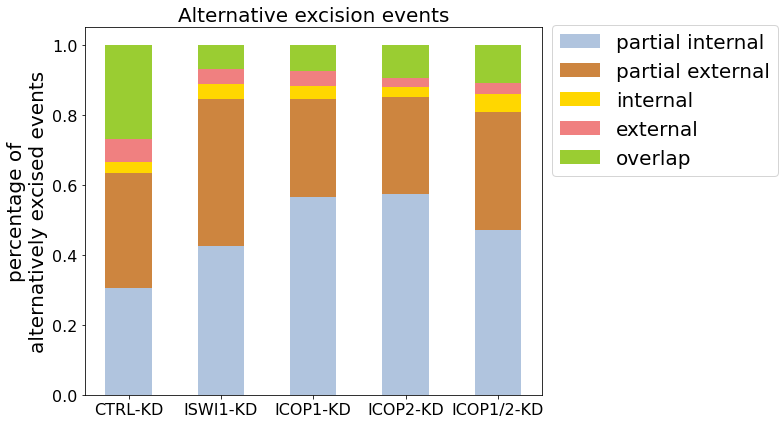

In [15]:
# stacked bar plot with percentage as y-axis
width = 0.5       # the width of the bars: can also be len(x) sequence
n_prop_p_internal = np.array(prop_p_internal)
n_prop_p_external = np.array(prop_p_external)
n_prop_internal = np.array(prop_internal)
n_prop_external = np.array(prop_external)
n_prop_overlap = np.array(prop_overlap)

# make figure
fig, ax = plt.subplots(figsize = (11,6))

ax.bar(headers, n_prop_p_internal, width, label='partial internal', color='lightsteelblue')
ax.bar(headers, n_prop_p_external, width, bottom=n_prop_p_internal, label='partial external', color='peru')
ax.bar(headers, n_prop_internal, width, bottom=(n_prop_p_internal+n_prop_p_external), label='internal', 
       color='gold')
ax.bar(headers, n_prop_external, width, bottom=(n_prop_p_internal+n_prop_p_external+n_prop_internal), 
       label='external', color='lightcoral')
ax.bar(headers, n_prop_overlap, width, label='overlap', color='yellowgreen',
       bottom=(n_prop_p_internal+n_prop_p_external+n_prop_internal+n_prop_external)) 

ax.set_ylabel('percentage of\nalternatively excised events', wrap = True, fontsize = 20)
ax.set_title('Alternative excision events', wrap = True, fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.80), fancybox=True, fontsize = 20);
fig.tight_layout()

#fig.savefig("ICOPs_ex_events_prop.pdf", bbox_inches='tight', transparent="True")

### Get the length differences for partial internal and partial external

In [16]:
#this script is to analyse parially internal and partially external excision
count = int(-1)
partial_storage = {}

for fn in fns:
    count += 1
    #store all internally exicised IESs with their length difference in a dict
    len_d_int = {}
    #store all externally exicised IESs with their length difference in a dict
    len_d_ext = {}
    
    # store the reference lengths of partial internally or externally excised IESs in lists
    pext_ref_len = []
    pint_ref_len = []

    
    for line in gzip.open(fn, mode='rt'):   
        if line[0] != '#':
            atoms = line.split()  
        
            ies_id = atoms[-1].split(";")[5].replace("ies_id=", '')
            kind = atoms[-1].split(";")[-2].replace("type=", '')
            subtype = atoms[-1].split(";")[-5].replace("subtype=", '')
            
            if kind == 'ALTERNATIVE':
                if subtype == 'PARTIAL_INTERNAL':
                    start = int(atoms[-1].split(";")[-6].replace("start=", ''))
                    end = int(atoms[-1].split(";")[4].replace("end=", ''))
                    calc_len = end - start
                    ref_ies_len = int(df_length.loc[df_length['IES_ID'] == ies_id]["ref_length"])
                    len_d_int.setdefault(ies_id, []).append(ref_ies_len - calc_len)
                    pint_ref_len.append(ref_ies_len)
            
                if subtype == 'PARTIAL_EXTERNAL':
                    start = int(atoms[-1].split(";")[-6].replace("start=", ''))
                    end = int(atoms[-1].split(";")[4].replace("end=", ''))
                    calc_len = end - start
                    ref_ies_len = int(df_length.loc[df_length['IES_ID'] == ies_id]["ref_length"])
                    len_d_ext.setdefault(ies_id, []).append(ref_ies_len - calc_len)
                    pext_ref_len.append(ref_ies_len)
                    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_lens_int = []
    for ies in len_d_int:
        for alen in len_d_int[ies]:
            all_lens_int.append(alen)
    
    #put the length differences (multiple for IESs possible) without IESs association in list
    all_ext_lens = []
    for ies in len_d_ext:
        for alen in len_d_ext[ies]:
            all_ext_lens.append(alen)
    
    #store both list in a list
    my_list = [all_ext_lens, all_lens_int]
    #store the name of the KD with both lists in the storage dict
    partial_storage[names[count]] = my_list
            
            


In [17]:
# get statictics for partial alternative excision

tab3_names = ['sample', 'pext_min', 'pext_max', 'pext_mean', 'pext_median',
              'pint_min', 'pint_max', 'pint_mean', 'pint_median']
tab3_cols = []

for na, lis in partial_storage.items():
    tab3_cols.append([na, min(lis[0]),max(lis[0]), np.mean(lis[0]),np.median(lis[0]),
                      min(lis[1]),max(lis[1]), np.mean(lis[1]),np.median(lis[1])])
table3 = pd.DataFrame(tab3_cols, columns = tab3_names)
print(table3)

#table3.to_csv("partex_partin_alt-ex.csv")

       sample  pext_min  pext_max   pext_mean  pext_median  pint_min  \
0     CTRL-KD     -4933        -1  -88.290909         -8.0         3   
1    ISWI1-KD     -9538        -1  -78.820146         -8.0         3   
2    ICOP1-KD     -8148        -1 -110.812112         -5.0         3   
3    ICOP2-KD     -7701        -1  -52.055346         -4.0         3   
4  ICOP1/2-KD     -9586        -1 -125.165339         -4.0         3   

   pint_max  pint_mean  pint_median  
0      3272  62.150628          7.0  
1      4357  21.800645         11.0  
2      2394  15.622647         10.0  
3      2049  15.660924         10.0  
4      3056  26.567147         11.0  


<ipython-input-21-42c5c38b94cc>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)


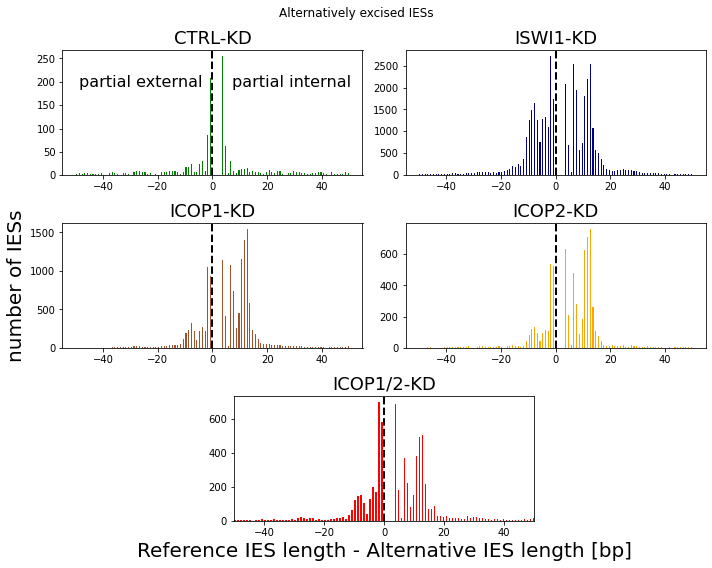

In [21]:
#set basic figure properties

fig, ax = plt.subplots(sharex=True, figsize = (10, 8));

ax0 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax1 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax2 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax4 = plt.subplot2grid((3,4), (2,1), colspan=2)

ax0.hist((partial_storage[names[0]][0], partial_storage[names[0]][1]), bins=range(-50, 51), fc='green', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax1.hist((partial_storage[names[1]][0], partial_storage[names[1]][1]), bins=range(-50, 51), fc='navy', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax2.hist((partial_storage[names[2]][0], partial_storage[names[2]][1]), bins=range(-50, 51), fc='sienna', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax3.hist((partial_storage[names[3]][0], partial_storage[names[3]][1]), bins=range(-50, 51), fc='orange', 
         label = ['externally excised IESs', 'internally excised IESs']);
ax4.hist((partial_storage[names[4]][0], partial_storage[names[4]][1]), bins=range(-50, 51), fc='red', 
         label = ['externally excised IESs', 'internally excised IESs']);


#add title to each subplot
ax0.set_title(names[0], fontsize = 18);
ax1.set_title(names[1], fontsize = 18);
ax2.set_title(names[2], fontsize = 18);
ax3.set_title(names[3], fontsize = 18);
ax4.set_title(names[4], fontsize = 18);

#add dashed vertical lines at x=0
ax0.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax1.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax2.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax3.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)
ax4.axvline(x=0, ymin=0, ymax=1, ls='--', color='black', lw=2)


#set the min and max for the x-axis (shared by all)
ax2.set_ylabel('number of IESs', fontsize=20);

ax4.set_xlim([-50,50]);
ax4.set_xlabel('Reference IES length - Alternative IES length [bp]', fontsize=20);

fig.suptitle("Alternatively excised IESs");

fig.text(0.20, 0.85, 'partial external', fontsize = 16, wrap=True,
         ha='center', va='center', rotation='horizontal');
fig.text(0.41, 0.85, 'partial internal', fontsize = 16,wrap=True,
         ha='center', va='center', rotation='horizontal');

fig.tight_layout();

#fig.savefig("ICOPs_down_int_ext_large.pdf",bbox_inches='tight')